# Vision Transformer with Knowledge Distillation and LWR

Training Visual Transformer on *Dogs vs Cats Data*
Reference - https://github.com/lucidrains/vit-pytorch


## Import Libraries

In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [4]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.0


In [5]:
# Training settings
batch_size = 16
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = 'cuda'

## Load Data

In [8]:
train_dir = 'data/train'
test_dir = 'data/test'

In [9]:
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip') as test_zip:
    test_zip.extractall('data')

In [10]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [12]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

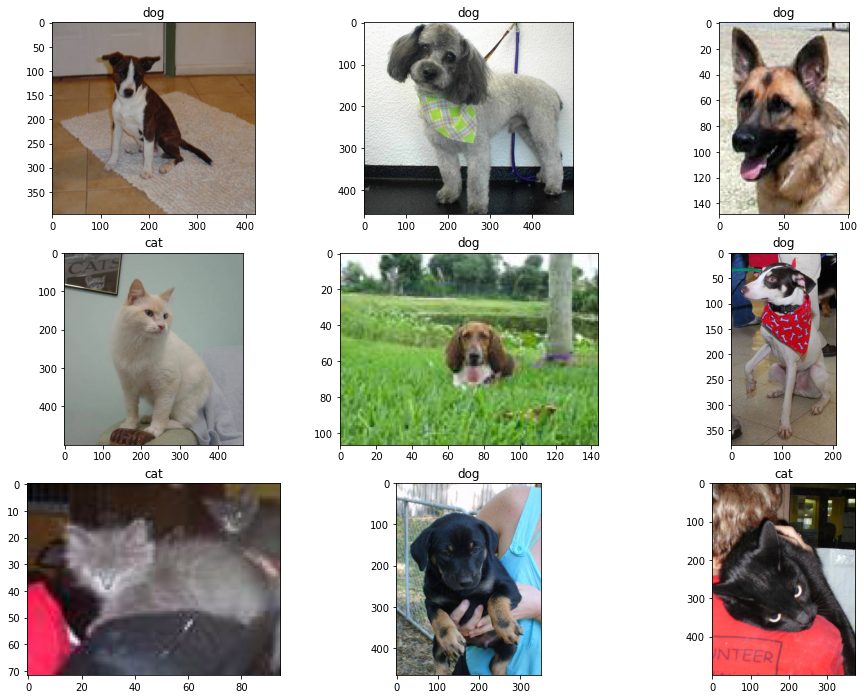

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augumentation

In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [17]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return idx, img_transformed, label


In [18]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

## Model Definition

In [22]:
from torchvision.models import resnet50

from vit_pytorch.distill import DistillableViT, DistillWrapper

teacher = resnet50(pretrained=True)

model = DistillableViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)
  #check the code

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### **Loss Function**

In [23]:
"""
Implements the knowledge distillation loss --- https://github.com/facebookresearch/deit/blob/main/losses.py
"""
import torch
from torch.nn import functional as F


class DistillationLoss(nn.Module):
    """
    This module wraps a standard criterion and adds an extra knowledge distillation loss by
    taking a teacher model prediction and using it as additional supervision.
    """
    def __init__(self, base_criterion: torch.nn.Module, teacher_model: torch.nn.Module,
                 distillation_type: str, alpha: float, tau: float, smoothing, retrospect):
        super().__init__()
        self.base_criterion = base_criterion
        self.teacher_model = teacher_model
        assert distillation_type in ['none', 'soft', 'hard']
        self.distillation_type = distillation_type
        self.alpha = alpha
        self.tau = tau
        self.batch_index = None
        self.smoothing = smoothing
        self.retrospect = retrospect

    def forward(self, inputs, outputs, labels, batch_index):
        outputs_kd = None
        self.batch_index = batch_index
        
        if not isinstance(outputs, torch.Tensor):
            # assume that the model outputs a tuple of [outputs, outputs_kd]
            outputs, outputs_kd = outputs
        
        if self.retrospect:
            assert self.batch_index!=None
            base_loss = self.base_criterion(batch_index, outputs, labels)
            
        else:
            base_loss = self.base_criterion(outputs, labels)


        if self.distillation_type == 'none':
            return base_loss

        if outputs_kd is None:
            raise ValueError("When knowledge distillation is enabled, the model is "
                             "expected to return a Tuple[Tensor, Tensor] with the output of the "
                             "class_token and the dist_token")

        with torch.no_grad():
            teacher_outputs = self.teacher_model(inputs)

        if self.distillation_type == 'soft':
            T = self.tau

            distillation_loss = F.kl_div(
                F.log_softmax(outputs_kd / T, dim=1),
                F.log_softmax(teacher_outputs / T, dim=1),
                reduction='sum',
                log_target=True
            ) * (T * T) / outputs_kd.numel()
        elif self.distillation_type == 'hard':
            distillation_loss = F.cross_entropy(outputs_kd, teacher_outputs.argmax(dim=1))

        loss = base_loss * (1 - self.alpha) + distillation_loss * self.alpha
        return loss

In [24]:
model=model.to(device)
teacher=teacher.to(device)

In [25]:
retrospect=True
smoothing=False

In [26]:
!pip install timm==0.3.2
from timm.loss import LabelSmoothingCrossEntropy

     |████████████████████████████████| 244 kB 870 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [27]:
import numpy as np
import torch
from torch import Tensor
from typing import Tuple
import torch.nn.functional as F


def soft_crossentropy(logits, y_true, dim):
    return -1 * (torch.log_softmax(logits, dim=dim) * y_true).sum(axis=1).mean(axis=0)


def crossentropy(logits, y_true, dim):
    if dim == 1:
        return F.cross_entropy(logits, y_true)
    else:
        loss = 0.
        for i in range(logits.shape[1]):
            loss += soft_crossentropy(
                logits[:, i, :],
                y_true[:, i, :],
                dim=1
            )
        return loss


class LWR(torch.nn.Module):
    def __init__(
        self,
        k: int,
        num_batches_per_epoch: int,
        dataset_length: int,
        output_shape: Tuple[int],
        max_epochs: int,
        tau=5.,
        update_rate=0.9,
        softmax_dim=1
    ):
        
        super().__init__()
        self.k = k
        self.update_rate = update_rate
        self.max_epochs = max_epochs

        self.step_count = 0
        self.epoch_count = 0
        self.num_batches_per_epoch = num_batches_per_epoch

        self.tau = tau
        self.alpha = 1.

        self.softmax_dim = softmax_dim

        self.labels = torch.zeros((dataset_length, *output_shape))

    def forward(
        self,
        batch_idx: Tensor,
        logits: Tensor,
        y_true: Tensor,
        eval=False
    ):
        self.alpha = 1 - self.update_rate * self.epoch_count * self.k / self.max_epochs
        if self.epoch_count <= self.k:
            self.step_count += 1
            if (self.step_count + 1) % self.num_batches_per_epoch == 0 and eval is False:
                self.step_count = 0
                self.epoch_count += 1

            if self.epoch_count == self.k and eval is False:
                # print(self.labels[batch_idx, ...].shape, logits.shape)
                self.labels[batch_idx, ...] = torch.softmax(
                    logits / self.tau, dim=self.softmax_dim).detach().clone().cpu()
            return F.cross_entropy(logits, y_true)
        else:
            if (self.epoch_count + 1) % self.k == 0 and eval is False:
                self.labels[batch_idx, ...] = torch.softmax(
                    logits / self.tau, dim=self.softmax_dim).detach().clone().cpu()
            return self.loss_fn_with_kl(logits, y_true, batch_idx)

    def loss_fn_with_kl(
        self,
        logits: Tensor,
        y_true: Tensor,
        batch_idx: Tensor,
    ):

        return self.alpha * crossentropy(logits, y_true, dim=self.softmax_dim) +\
            (1 - self.alpha) * self.tau * self.tau *\
            F.kl_div(
                F.log_softmax(logits / self.tau, dim=self.softmax_dim),
                self.labels[batch_idx, ...].to(logits.get_device()),
                reduction='batchmean'
        )

In [38]:
smoothing = False
retrospect = True

value = 0.1 
if smoothing : 
    base_criterion = LabelSmoothingCrossEntropy(smoothing = value)
    
elif retrospect: 
    base_criterion = LWR(
    k=1,
    update_rate=0.9,
    num_batches_per_epoch=len(train_data) // batch_size,
    dataset_length=len(train_data),
    output_shape=(2, ),
    tau=5,
    max_epochs=20,
    softmax_dim=1
)
      
else : 
    base_criterion = nn.CrossEntropyLoss()

criterion = DistillationLoss(
    base_criterion, teacher, 'none', 0.5, 1.0, smoothing, retrospect)

In [35]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)  

## Training loop

In [39]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_idx, data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data).to(device)
        loss = criterion(data, output, label, batch_idx)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        batch_idx+=1

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0

        for val_batch_idx, data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data).to(device)
            val_loss = criterion(data, val_output, label, val_batch_idx)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.6833 - acc: 0.5615 - val_loss : 0.6714 - val_acc: 0.5859




Epoch : 2 - loss : 0.6614 - acc: 0.5736 - val_loss : 0.6012 - val_acc: 0.6058




Epoch : 3 - loss : 0.5981 - acc: 0.6030 - val_loss : 0.5877 - val_acc: 0.6212




Epoch : 4 - loss : 0.5835 - acc: 0.6211 - val_loss : 0.5660 - val_acc: 0.6452




Epoch : 5 - loss : 0.5613 - acc: 0.6500 - val_loss : 0.5612 - val_acc: 0.6436




Epoch : 6 - loss : 0.5493 - acc: 0.6616 - val_loss : 0.5361 - val_acc: 0.6723




Epoch : 7 - loss : 0.5425 - acc: 0.6737 - val_loss : 0.5377 - val_acc: 0.6735




Epoch : 8 - loss : 0.5375 - acc: 0.6807 - val_loss : 0.5324 - val_acc: 0.6785




Epoch : 9 - loss : 0.5289 - acc: 0.6884 - val_loss : 0.5243 - val_acc: 0.6983




Epoch : 10 - loss : 0.5294 - acc: 0.6858 - val_loss : 0.5253 - val_acc: 0.7005




Epoch : 11 - loss : 0.5208 - acc: 0.6966 - val_loss : 0.5214 - val_acc: 0.6945




Epoch : 12 - loss : 0.5135 - acc: 0.7037 - val_loss : 0.5075 - val_acc: 0.7037




Epoch : 13 - loss : 0.5107 - acc: 0.7057 - val_loss : 0.5093 - val_acc: 0.7043




Epoch : 14 - loss : 0.5088 - acc: 0.7067 - val_loss : 0.5093 - val_acc: 0.7155




Epoch : 15 - loss : 0.5069 - acc: 0.7086 - val_loss : 0.4959 - val_acc: 0.7208




Epoch : 16 - loss : 0.5014 - acc: 0.7153 - val_loss : 0.5024 - val_acc: 0.7057




Epoch : 17 - loss : 0.5037 - acc: 0.7139 - val_loss : 0.4990 - val_acc: 0.7187




Epoch : 18 - loss : 0.4965 - acc: 0.7175 - val_loss : 0.4959 - val_acc: 0.7260




Epoch : 19 - loss : 0.4965 - acc: 0.7213 - val_loss : 0.4938 - val_acc: 0.7206




Epoch : 20 - loss : 0.4940 - acc: 0.7206 - val_loss : 0.5431 - val_acc: 0.6729



### Save weights

In [42]:

torch.save(model.state_dict(), 'ViT_LWR.pth')